In [2]:
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.datasets import imdb 
from sklearn.metrics import classification_report

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Embedding, Dropout, Flatten, Layer, Input, Reshape,Concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics

In [6]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
lm = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics, svm
import string

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
from sklearn.model_selection import train_test_split

In [7]:
n_unique_words = 10000
(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words=n_unique_words)

In [8]:
maxlen = 200
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [104]:
x_train[0].shape

(200,)

In [6]:
#pure bilstm
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [7]:
#model.fit(x_train, y_train, validation_split = 0.2,epochs = 12, verbose = True,batch_size = 64)

In [49]:
class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(Attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(Attention,self).get_config()

In [38]:
inp = Input(shape=(200, ))
x = Embedding(10000, 128, trainable=False)(inp)
conv_1 = Conv1D(32, 9, activation='relu', name='conv1d_1')(x)
maxpool_1 = MaxPooling1D(16, name='maxpool1d_1')(conv_1)
dropout_1 = Dropout(0.2, name='dropout_1')(maxpool_1)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25,recurrent_dropout=0.25))(dropout_1)
x = Attention()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_12 (Embedding)    (None, 200, 128)          1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 32)           36896     
                                                                 
 maxpool1d_1 (MaxPooling1D)  (None, 12, 32)            0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 32)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 12, 128)          49664     
 onal)                                                           
                                                           

In [39]:
def callbacks(**kwargs):
    mc = ModelCheckpoint(filepath = kwargs.get("filename"), save_best_only = True, verbose = 0)
    es = EarlyStopping(monitor = kwargs.get("monitor"), patience = kwargs.get("patience"))
    return mc,es

In [40]:
mc,es = callbacks(filename = "./cnn_bilstm.h5", patience = 3, monitor = "val_loss")

In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#file_path = 'model.hdf5'
#ckpt = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early = EarlyStopping(monitor="val_loss", mode="min", patience=1)

In [42]:
model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.2,callbacks=[mc,es])

Epoch 1/20
79/79 [==============================] - 19s 179ms/step - loss: 0.6889 - accuracy: 0.5337 - val_loss: 0.6628 - val_accuracy: 0.5972
Epoch 2/20
79/79 [==============================] - 14s 173ms/step - loss: 0.6039 - accuracy: 0.6755 - val_loss: 0.5384 - val_accuracy: 0.7326
Epoch 3/20
79/79 [==============================] - 14s 174ms/step - loss: 0.5147 - accuracy: 0.7505 - val_loss: 0.5073 - val_accuracy: 0.7514
Epoch 4/20
79/79 [==============================] - 14s 176ms/step - loss: 0.4641 - accuracy: 0.7862 - val_loss: 0.4748 - val_accuracy: 0.7680
Epoch 5/20
79/79 [==============================] - 14s 181ms/step - loss: 0.4103 - accuracy: 0.8184 - val_loss: 0.4901 - val_accuracy: 0.7654
Epoch 6/20
79/79 [==============================] - 14s 183ms/step - loss: 0.3811 - accuracy: 0.8316 - val_loss: 0.4464 - val_accuracy: 0.7908
Epoch 7/20
79/79 [==============================] - 15s 184ms/step - loss: 0.3389 - accuracy: 0.8550 - val_loss: 0.4554 - val_accuracy: 0.7880

In [43]:
y_pred = model.predict(x_test)

782/782 [==============================] - 7s 9ms/step


In [44]:
y_pred.shape

(25000, 1)

In [45]:
y_test.shape

(25000,)

In [46]:
y_pred_p = (y_pred > 0.5).astype('int64')

In [47]:
print(classification_report(y_test, y_pred_p))

              precision    recall  f1-score   support

           0       0.85      0.71      0.77     12500
           1       0.75      0.87      0.80     12500

    accuracy                           0.79     25000
   macro avg       0.80      0.79      0.79     25000
weighted avg       0.80      0.79      0.79     25000



In [48]:
new_df = pd.read_csv('Data_set.txt',delimiter = "\t",encoding='latin-1')

In [49]:
new_df.head()

,Rating,Description
0,0,what's surprising about this traditional thril...
1,0,the essential problem in orange county is that...
2,1,a devastating indictment of unbridled greed an...
3,1,a breezy romantic comedy that has the punch of...
4,1,drumline ably captures the complicated relatio...


In [50]:
y = new_df['Rating']
X = new_df['Description']
def clean_data(data):
    data = data.replace("\n", "")
    data = re.sub(r'\W', ' ', data)
    data = re.sub(r'\s+[a-zA-Z]\s+', ' ', data)
    data = re.sub(r'\s+', ' ', data, flags=re.I)
    data = data.lower().split(" ")
    data = [word for word in data if word not in set(stopwords.words("english"))]                                            
    data = ' '.join([str(elem) for elem in data])
    return data

In [51]:
incrementer=0
for i in X:
    i = clean_data(i)
    X[incrementer]=i
    incrementer+=1

C:\Users\HP\AppData\Local\Temp\ipykernel_20368\2672807160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[incrementer]=i


In [52]:
incrementer=0
for i in X:
    listw = nltk.word_tokenize(i)
    lemmatized_string = ' '.join([lm.lemmatize(words) for words in listw])
    X[incrementer]=lemmatized_string
    incrementer+=1

C:\Users\HP\AppData\Local\Temp\ipykernel_20368\3635973817.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[incrementer]=lemmatized_string


In [18]:

#sentences_train, sentences_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [115]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
print(X_train[0])
vocab_size = len(tokenizer.word_index) + 1 
print(vocab_size)

[745, 291, 88, 746, 122, 549, 350, 69, 519, 3, 216, 401]
14436


In [107]:
maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train[0].shape

(200,)

In [108]:
vocab_size

14436

In [109]:
inp = Input(shape=(200, ))
x = Embedding(14436, 128, trainable=False)(inp)
conv_1 = Conv1D(32, 9, activation='relu', name='conv1d_1')(x)
maxpool_1 = MaxPooling1D(16, name='maxpool1d_1')(conv_1)
dropout_1 = Dropout(0.2, name='dropout_1')(maxpool_1)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25,recurrent_dropout=0.25))(dropout_1)
x = Attention()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_15 (Embedding)    (None, 200, 128)          1847808   
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 32)           36896     
                                                                 
 maxpool1d_1 (MaxPooling1D)  (None, 12, 32)            0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 32)            0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 12, 128)          49664     
 onal)                                                           
                                                           

In [110]:
def callbacks(**kwargs):
    mc = ModelCheckpoint(filepath = kwargs.get("filename"), save_best_only = True, verbose = 0)
    es = EarlyStopping(monitor = kwargs.get("monitor"), patience = kwargs.get("patience"))
    return mc,es
mc,es = callbacks(filename = "./cnn_bilstm.h5", patience = 3, monitor = "val_loss")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2,callbacks=[mc,es])

Epoch 1/20
100/100 [==============================] - 10s 51ms/step - loss: 0.6903 - accuracy: 0.5439 - val_loss: 0.6881 - val_accuracy: 0.5506
Epoch 2/20
100/100 [==============================] - 5s 47ms/step - loss: 0.6903 - accuracy: 0.5457 - val_loss: 0.6890 - val_accuracy: 0.5506
Epoch 3/20
100/100 [==============================] - 5s 50ms/step - loss: 0.6892 - accuracy: 0.5444 - val_loss: 0.6890 - val_accuracy: 0.5506
Epoch 4/20
100/100 [==============================] - 5s 51ms/step - loss: 0.6723 - accuracy: 0.5813 - val_loss: 0.6868 - val_accuracy: 0.5638
Epoch 5/20
100/100 [==============================] - 5s 51ms/step - loss: 0.6229 - accuracy: 0.6534 - val_loss: 0.7013 - val_accuracy: 0.5581
Epoch 6/20
100/100 [==============================] - 5s 51ms/step - loss: 0.5626 - accuracy: 0.7042 - val_loss: 0.7231 - val_accuracy: 0.5631
Epoch 7/20
100/100 [==============================] - 5s 51ms/step - loss: 0.5051 - accuracy: 0.7378 - val_loss: 0.7885 - val_accuracy: 0.568

In [111]:
y_pred = model.predict(X_test)

84/84 [==============================] - 1s 6ms/step


In [112]:
y_pred_p = (y_pred > 0.5).astype('int64')

In [113]:
print(classification_report(y_test, y_pred_p))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67      1492
           1       0.54      0.38      0.45      1174

    accuracy                           0.58      2666
   macro avg       0.57      0.56      0.56      2666
weighted avg       0.58      0.58      0.57      2666



In [11]:
df_imdb = pd.read_csv('C:/Users/HP/IMDB Dataset/IMDB Dataset.csv')

In [12]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df_imdb['review'] = df_imdb['review'].str.lower()

In [12]:
import string

In [13]:
def remove_stopwords(df_imdb):
    df_imdb['review without stopwords'] = df_imdb['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords.words("english"))]))
    return df_imdb

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

def stringprocess(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"http\S+","URL", text)
    text = re.sub(r"@", "", text)
    text = re.sub(r"[^A-Za-z0-9()!?\'\`\"]", " ", text)
    text = re.sub(r'[^\w\d\s\']+', '', text)
    text = re.sub("\s{2,}", " ", text)
    text = text.strip(' ')
    text = text.lower()
    
    return text
    


In [17]:
data_without_stopwords = df_imdb.copy(deep=True)
data_without_stopwords['clean_review']= data_without_stopwords['review'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review']= data_without_stopwords['clean_review'].apply(lambda cw : stringprocess(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

C:\Users\HP\AppData\Local\Temp\ipykernel_18088\2176296075.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')


In [18]:
#data_without_stopwords.to_csv('IMDB Dataset/cleaned_data.csv')
reviews = data_without_stopwords['clean_review']

In [19]:
from nltk.tokenize import word_tokenize
def stopwords_removal(sent):
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(sent)
   
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
   
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    newsent = ' '.join(filtered_sentence)

    #print(word_tokens)
    return newsent

In [20]:
cleaner_reviews_list = []
for i in data_without_stopwords['clean_review']:
    new_sent = stopwords_removal(i)
    #new_sent = re.sub(r"br", " ", new_sent)
    new_sent = remove_tags(new_sent)
    new_sent = stringprocess(new_sent)
    cleaner_reviews_list.append(new_sent)

In [21]:
cleaner_reviews_list[0]

'one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lac

In [22]:
lemmatizer = WordNetLemmatizer()
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:     
        return None

In [23]:
reviews_list = []
for i in range(len(cleaner_reviews_list)):
    cleaned_singles = ' '.join( [w for w in cleaner_reviews_list[i].split() if len(w)>1] )
    cleaned_singles = ''.join([i for i in cleaned_singles if not i.isdigit()])
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(cleaned_singles))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    reviews_list.append(lemmatized_sentence)

In [24]:
reviews_list_cl = []
for i in reviews_list:
    i = re.sub(r"br", "", i)
    reviews_list_cl.append(i)

In [25]:
reviews_list_cl[0]

'one reviewer mention watch oz episode hook right exactly happen first thing strike oz utality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangstas latinos christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture paint mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watch developed taste oz get accustomed high level graphic violence violence injustice crook guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may become c

In [27]:
cleaned_df = pd.DataFrame(list(zip(reviews_list_cl, data_without_stopwords['sentiment'])),columns = ['cleaned_review','sentiment'])

In [29]:
cleaned_df.to_csv('IMDB Dataset/cleaned_data.csv')

In [41]:
sentiment = cleaned_df_non['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiment)))

In [42]:
X_train, X_test,Y_train, Y_test = train_test_split(non_english_removal, y, test_size=0.2, random_state = 45)

In [43]:
X_train[90]

'perhaps movie meant nothing funny maybe meant get teenage boy excited nudity get actually something many people believe nice guy finish last line angel heart character say take bad as make girl heart beat fast true likely woman always say want flower candy politeness whatever least early age end go good look slimy disrespectful untamed guy one know conform belief part attraction excite guy already way want believe may happen say film disguise sex nudity party everything else teens relate get heart happen everyone happen strong final statement film say movie fun funny show antic quite well rare film enough please teenage crowd also intelligent poignant enough show like get heart film ever do well like say think writer must experience situation like first hand maybe old film ever come across gather dust shelf local video store one night pick may surprise hell lot well never kiss'

In [44]:
len(Y_train)

40000

In [45]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
     

words_to_index = tokenizer.word_index
     

len(words_to_index)

28944

In [46]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map
    
     

In [47]:
word_to_vec_map = read_glove_vector('C:/Users/HP/Downloads/glove.6B/glove.6B.200d.txt')

In [48]:
maxLen = 200
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector






In [110]:
inp = Input(shape=(200, ))
x = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)(inp)
conv_1 = Conv1D(128, 3, activation='relu', name='conv1d_1')(x)
maxpool_1 = MaxPooling1D(3)(conv_1)
dropout_1 = Dropout(0.2, name='dropout_3')(maxpool_1)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25,recurrent_dropout=0.25))(dropout_1)
x = Attention()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 200, 200)          5788800   
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 128)          76928     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 66, 128)          0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 66, 128)           0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 66, 128)          98816     
 onal)                                                     

In [54]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
     

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(40000, 200)

In [55]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
     

In [113]:
def callbacks(**kwargs):
    mc = ModelCheckpoint(filepath = kwargs.get("filename"), save_best_only = True, verbose = 0)
    es = EarlyStopping(monitor = kwargs.get("monitor"), patience = kwargs.get("patience"))
    return mc,es
mc,es = callbacks(filename = "./cnn_bilstm.h5", patience = 3, monitor = "val_loss")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_indices, Y_train, batch_size=128, epochs=20, validation_split=0.2,callbacks=[mc,es])

Epoch 1/20
250/250 [==============================] - 229s 901ms/step - loss: 0.4595 - accuracy: 0.7805 - val_loss: 0.3609 - val_accuracy: 0.8432
Epoch 2/20
250/250 [==============================] - 236s 943ms/step - loss: 0.3487 - accuracy: 0.8486 - val_loss: 0.3356 - val_accuracy: 0.8568
Epoch 3/20
250/250 [==============================] - 226s 904ms/step - loss: 0.3067 - accuracy: 0.8693 - val_loss: 0.3266 - val_accuracy: 0.8580
Epoch 4/20
250/250 [==============================] - 226s 905ms/step - loss: 0.2821 - accuracy: 0.8841 - val_loss: 0.3262 - val_accuracy: 0.8636
Epoch 5/20
250/250 [==============================] - 224s 896ms/step - loss: 0.2594 - accuracy: 0.8947 - val_loss: 0.3160 - val_accuracy: 0.8652
Epoch 6/20
250/250 [==============================] - 222s 890ms/step - loss: 0.2335 - accuracy: 0.9071 - val_loss: 0.3421 - val_accuracy: 0.8619
Epoch 7/20
250/250 [==============================] - 223s 893ms/step - loss: 0.2205 - accuracy: 0.9121 - val_loss: 0.3470 -

In [127]:
y_pred = model.predict(X_test_indices)

313/313 [==============================] - 18s 59ms/step


In [118]:
y_pred_p = [1  if x >  0.5 else 0 for x in y_pred ]

In [119]:
print(classification_report(Y_test, y_pred_p))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      5035
           1       0.85      0.91      0.88      4965

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [120]:
print(confusion_matrix(Y_test,y_pred_p))
print(classification_report(Y_test,y_pred_p))
print(accuracy_score(Y_test, y_pred_p))

[[4238  797]
 [ 433 4532]]
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      5035
           1       0.85      0.91      0.88      4965

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

0.877


In [65]:
cleaned_df.head()

,cleaned_review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


In [125]:
word_to_vec_map = read_glove_vector('C:/Users/HP/Downloads/glove.6B/glove.6B.200d.txt')
maxLen = 200
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector
inp = Input(shape=(200, ))
x = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)(inp)
conv_1 = Conv1D(128, 3, activation='relu', name='conv1d_1')(x)
maxpool_1 = MaxPooling1D(3)(conv_1)
#dropout_1 = Dropout(0.2, name='dropout_3')(maxpool_1)
##LSTM_1
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25,recurrent_dropout=0.25))(maxpool_1)
x = Attention()(x)
##LSTM_2
y = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25,recurrent_dropout=0.25))(maxpool_1)
y = Attention()(y)
#Combination
z = Concatenate(name="concatenate")([x,y])
z = Dense(64, activation="relu")(z)
z = Dropout(0.25)(z)
z = Dense(1, activation="sigmoid")(z)
new_model = Model(inputs=inp, outputs=z)
new_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 200, 200)     5788800     ['input_19[0][0]']               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 198, 128)     76928       ['embedding_18[0][0]']           
                                                                                                  
 max_pooling1d_18 (MaxPooling1D  (None, 66, 128)     0           ['conv1d_1[0][0]']               
 )                                                                                         

In [126]:
def callbacks(**kwargs):
    mc = ModelCheckpoint(filepath = kwargs.get("filename"), save_best_only = True, verbose = 0)
    es = EarlyStopping(monitor = kwargs.get("monitor"), patience = kwargs.get("patience"))
    return mc,es
mc,es = callbacks(filename = "./cnn_bilstm.h5", patience = 3, monitor = "val_loss")
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
new_model.fit(X_train_indices, Y_train, batch_size=128, epochs=20, validation_split=0.2,callbacks=[mc,es])

Epoch 1/20
250/250 [==============================] - 555s 2s/step - loss: 0.4373 - accuracy: 0.7931 - val_loss: 0.3670 - val_accuracy: 0.8380
Epoch 2/20
250/250 [==============================] - 551s 2s/step - loss: 0.3304 - accuracy: 0.8603 - val_loss: 0.3309 - val_accuracy: 0.8614
Epoch 3/20
250/250 [==============================] - 551s 2s/step - loss: 0.2995 - accuracy: 0.8748 - val_loss: 0.3210 - val_accuracy: 0.8641
Epoch 4/20
250/250 [==============================] - 552s 2s/step - loss: 0.2582 - accuracy: 0.8954 - val_loss: 0.3139 - val_accuracy: 0.8674
Epoch 5/20
250/250 [==============================] - 554s 2s/step - loss: 0.2272 - accuracy: 0.9114 - val_loss: 0.3484 - val_accuracy: 0.8584
Epoch 6/20
250/250 [==============================] - 552s 2s/step - loss: 0.2084 - accuracy: 0.9175 - val_loss: 0.3967 - val_accuracy: 0.8430
Epoch 7/20
250/250 [==============================] - 548s 2s/step - loss: 0.1718 - accuracy: 0.9351 - val_loss: 0.3673 - val_accuracy: 0.8586

In [128]:
y_pred = new_model.predict(X_test_indices)
y_pred_p = [1  if x >=  0.5 else 0 for x in y_pred ]
print(confusion_matrix(Y_test,y_pred_p))
print(classification_report(Y_test,y_pred_p))
print(accuracy_score(Y_test, y_pred_p))

313/313 [==============================] - 26s 81ms/step
[[4028 1007]
 [ 344 4621]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      5035
           1       0.82      0.93      0.87      4965

    accuracy                           0.86     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.86      0.86     10000

0.8649


In [19]:
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [20]:
non_english_removal = []
for sent in cleaned_df.cleaned_review:
    cleaned_sent = " ".join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() in words or not w.isalpha())
    non_english_removal.append(cleaned_sent)

In [23]:
cleaned_df_non = pd.DataFrame(list(zip(non_english_removal, cleaned_df['sentiment'])),columns = ['cleaned_review','sentiment'])

In [26]:
cleaned_df_non.to_csv('IMDB Dataset/cleaned_data_non.csv')

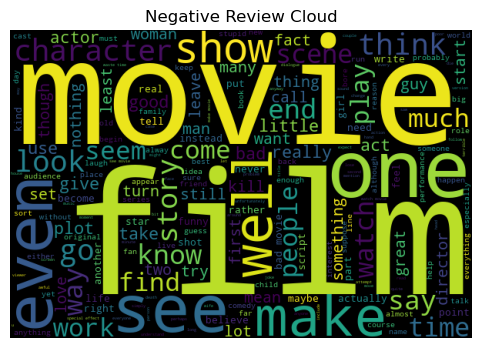

In [31]:
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
import seaborn as sns
# remove punctuations & tokenize
tokenizer = RegexpTokenizer(r'\w+')
cleaned_df_non['tokens'] = cleaned_df_non['cleaned_review'].apply(tokenizer.tokenize)

rvw_tokens = ''
for tokens in cleaned_df_non[cleaned_df_non['sentiment'] == 'negative']['tokens']:
    rvw_tokens += " ".join(tokens)
    
wordcloud = WordCloud(width=600, height=400).generate(rvw_tokens)

plt.figure(figsize = (6, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Negative Review Cloud')
plt.show()

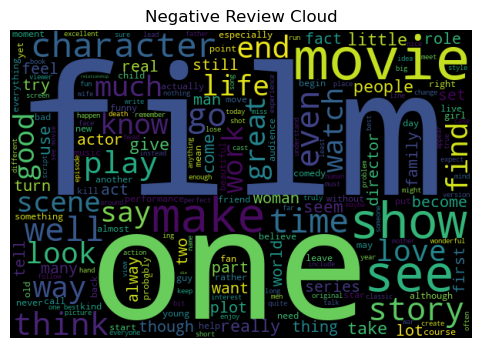

In [32]:
rvw_tokens = ''
for tokens in cleaned_df_non[cleaned_df_non['sentiment'] == 'positive']['tokens']:
    rvw_tokens += " ".join(tokens)
    
wordcloud = WordCloud(width=600, height=400).generate(rvw_tokens)

plt.figure(figsize = (6, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Negative Review Cloud')
plt.show()

In [33]:
def extract_ngrams(tokens, num):
    n_grams = ngrams(tokens, num)
    n_grams = [ ' '.join(grams) for grams in n_grams]
    return n_grams

def count_ngrams(df, num):
    gram_dict = {}
    for i in df:
        grams = extract_ngrams(i, num)
        for j in grams:
            if j in gram_dict:
                gram_dict[j] += 1
            else:
                gram_dict[j] = 1
    gram_dict = dict(sorted(gram_dict.items(), key=lambda item: item[1], reverse=True))
    return gram_dict

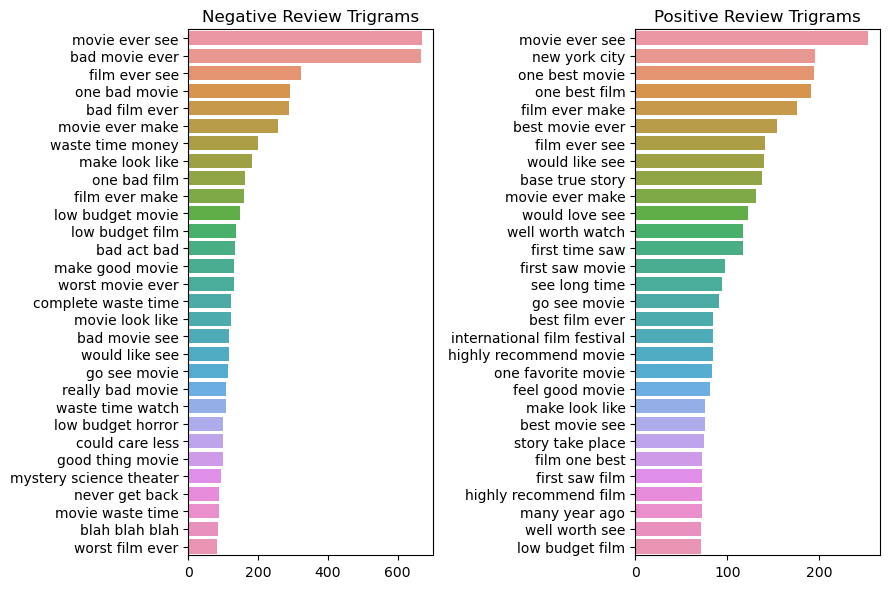

In [39]:
bigrams_neg = count_ngrams(cleaned_df_non[cleaned_df_non['sentiment']=='negative']['tokens'], 3)
bigrams_pos = count_ngrams(cleaned_df_non[cleaned_df_non['sentiment']=='positive']['tokens'], 3)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
num = 30
sns.barplot(x=list(bigrams_neg.values())[:num], y=list(bigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(bigrams_pos.values())[:num], y=list(bigrams_pos.keys())[:num], ax=axes[1])

axes[0].set_title('Negative Review Trigrams')
axes[1].set_title('Positive Review Trigrams')

plt.tight_layout()
plt.show()

In [40]:
cleaned_df_non.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64